In [0]:
#importing the essential libraries for plotting graph and dealing with data
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [0]:
dataset = pd.read_csv('/content/drive/My Drive/NLP/housing.csv')
dataset = dataset.dropna()
print("Here are the first 10 rows of the dataset: ")
dataset.head(10)

Here are the first 10 rows of the dataset: 


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc03661c128>,
      dtype=object)

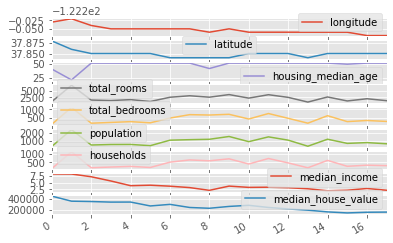

In [0]:
#ggplot is used to plot the graph 
plt.style.use("ggplot")
dataset.head(18).plot(subplots=True)

In [0]:
Y = dataset['median_house_value']
X = dataset.loc[:,'longitude':'median_income']

In [0]:
#the dataset is seperated out in training and testing data i ratio of 70:30 and random state of 2003
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 2003)
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()
x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#major layers libraries are imported from torch.nn 
import torch
from torch.nn import Conv1d
from torch.nn import BatchNorm1d
from torch.nn.functional import relu
from torch.nn import Softmax
from torch.nn import MaxPool1d
from torch.nn import Dropout
from torch.nn import AvgPool1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.utils.data import DataLoader, TensorDataset

In [0]:
#major python class that takes in the input and provides the processed output
class CnnRegressor(torch.nn.Module):
  def __init__(self, batch_size, inputs, outputs):
    super(CnnRegressor, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs
    self.batch_normaliztion_1=BatchNorm1d(inputs)
    self.input_layer = Conv1d(inputs, batch_size, kernel_size=1)
    self.max_pooling_layer = MaxPool1d(1)
    self.conv_layer = Conv1d(batch_size, 128, 1)
    self.drop_out_1=Dropout(0.2)
    self.average_pooling_layer = AvgPool1d(1)
    self.flatten_layer = Flatten()
    self.flatten_layer1 = Flatten()
    self.softmax = Softmax(dim=1)
    self.linear_layer = Linear(128, 64)
    self.linear_layer1 = Linear(64, 32)
    self.output_layer = Linear(32, outputs)

  def feed(self, input):
    input = input.reshape((self.batch_size, self.inputs, 1))
    output=self.batch_normaliztion_1(input)
    output = relu(self.input_layer(output))
    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer(output))
    output= self.drop_out_1(output)
    output = self.average_pooling_layer(output)
    output = self.flatten_layer(output)
    output = self.flatten_layer1(output)
    output = self.softmax(output)
    output = self.linear_layer(output)
    output = self.linear_layer1(output)
    output = self.output_layer(output)
    return output

In [0]:
from torch.optim import Adamax
from torch.nn import L1Loss
from torch.nn import MSELoss
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

In [0]:
batch_size = 250
model = CnnRegressor(batch_size, X.shape[1], 1)
model.cuda()

CnnRegressor(
  (batch_normaliztion_1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (input_layer): Conv1d(8, 250, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(250, 128, kernel_size=(1,), stride=(1,))
  (drop_out_1): Dropout(p=0.2, inplace=False)
  (average_pooling_layer): AvgPool1d(kernel_size=(1,), stride=(1,), padding=(0,))
  (flatten_layer): Flatten()
  (flatten_layer1): Flatten()
  (softmax): Softmax(dim=1)
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (linear_layer1): Linear(in_features=64, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)

In [0]:
#model loss is computed while computing the output 
def model_loss(model, dataset, train = False, optimizer = None):
  performance = L1Loss()
  performance1 = MSELoss()
  score_metric = R2Score()

  avg_loss = 0
  avg_loss1 = 0
  avg_score = 0
  count = 0

  for input, output in iter(dataset):
    predictions = model.feed(input)
    loss = performance(predictions, output)
    loss1 = performance1(predictions, output)
    score_metric.update([predictions, output])
    score = score_metric.compute()
    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    avg_loss += loss.item()
    avg_score += score
    avg_loss1 += loss1.item()
    count += 1
  return avg_loss / count, avg_loss1 / count, avg_score / count

In [0]:
epochs = 500
optimizer = Adamax(model.parameters(), lr = 1e-2)
inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0], 1)).cuda().float()

tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle = True, drop_last = True)

lossData = []
loss1Data = []
R2ScoreData = []
epochData = []

for epoch in range(epochs):
  avg_loss,avg_loss1, avg_r2_score = model_loss(model, loader, train = True, optimizer = optimizer)

  print("Epoch " + str(epoch + 1) + ":\n\tLoss = " + str(avg_loss) + ":\n\tMSELoss = " + str(avg_loss1) + "\n\tR^2Score = " + str(avg_r2_score))

  epochData.append(epoch + 1)
  lossData.append(avg_loss)
  loss1Data.append(avg_loss1)
  R2ScoreData.append(avg_r2_score)

Epoch 1:
	Loss = 39910.22909813596:
	MSELoss = 3660337306.9473686
	R^2Score = 0.714485537172473
Epoch 2:
	Loss = 38249.86355537281:
	MSELoss = 3410415654.1754384
	R^2Score = 0.7393316425161357
Epoch 3:
	Loss = 38273.29577850877:
	MSELoss = 3380639631.7192984
	R^2Score = 0.7503553507321736
Epoch 4:
	Loss = 38649.52206688596:
	MSELoss = 3438872266.105263
	R^2Score = 0.7499517729164068
Epoch 5:
	Loss = 38159.05578399123:
	MSELoss = 3414556757.3333335
	R^2Score = 0.7307845880544721
Epoch 6:
	Loss = 38534.9921189693:
	MSELoss = 3447935238.736842
	R^2Score = 0.7516237180448586
Epoch 7:
	Loss = 37983.27840597588:
	MSELoss = 3370486954.6666665
	R^2Score = 0.7503691309071427
Epoch 8:
	Loss = 38078.678728070176:
	MSELoss = 3370411573.894737
	R^2Score = 0.748587394081117
Epoch 9:
	Loss = 38581.15148711623:
	MSELoss = 3519596885.3333335
	R^2Score = 0.721956520167125
Epoch 10:
	Loss = 38066.47066885965:
	MSELoss = 3373120902.736842
	R^2Score = 0.7482118537827945
Epoch 11:
	Loss = 37751.684279057015

In [0]:
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()

tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle = True, drop_last = True)

avg_loss,avg_loss1,avg_r2_score = model_loss(model, loader)

print("The model's L1 loss is: " + str(avg_loss))
print("The model's MSE loss is: " + str(avg_loss1))
print("The model's R^2 score is: " + str(avg_r2_score))

The model's L1 loss is: 37247.91796875
The model's MSE loss is: 3388064512.0
The model's R^2 score is: 0.758750343947518


In [0]:
model_save_name = '0876833_1dcnn.pt'
path = F"//content/drive/My Drive/NLP_ass/0876833_1dcnn" 
torch.save(model.state_dict(), path)